lstm2

과정 요약:<br> 
feature: season, day of week, week number, sales <br> 
feature engineering: normalize+ denormalize

결과요약: seed 7: rmse 96.04 (마지막 

상세과정:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 
이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

추가의견) 개인적으로 이상점을 제거한 후 normalize를 하면 rmse가 커질 수 밖에 없다고 생각함. 다음시도(lstm3)은 이상점을 제거하지 않고 normalize를 하고, lstm4에서는 이상점을 제거하고 normalize를 하지 않는 것을 시도하겠다.

추가의견2) 처음에는 denormalize과정 없이 rmse를 구했는데, 이것보다는 denormalize를 한 후 rmse를 구하여 모델간 비교를 하는 것이 더 적절한 것 같다. normalize는 어디까지나 변환이니 항상 변환을 할때는 역변환을 하여 원본 데이터 형태m로 생각하는 것이 덜 헷갈리고, 결과값에 대한 더욱 직관적인 이해가 가능할 것 같다. 그리고, 여러 형태의 data transformation이 있는데 normalize 가장 마지막 단계의 data transformation인 것 같다. 다른 로그나 루트 변환을 한 후 normalization을 하고, 그리고 예측값이 모델을 통해 생성되면 바로 denormalize하고...예측(뉴럴) 모델의 input직전과 output직후.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime   

set seednumber(7 or 77)

In [2]:
tf.set_random_seed(77)

# 1. DATA 준비

In [3]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [4]:
sales=list(txs['sales'])

In [5]:
sales

[34,
 41,
 54,
 41,
 35,
 44,
 50,
 42,
 42,
 66,
 50,
 55,
 56,
 53,
 44,
 54,
 54,
 50,
 40,
 49,
 28,
 72,
 71,
 53,
 43,
 38,
 55,
 49,
 43,
 49,
 49,
 44,
 39,
 52,
 45,
 33,
 43,
 40,
 46,
 49,
 50,
 37,
 37,
 45,
 48,
 48,
 38,
 60,
 31,
 35,
 53,
 70,
 62,
 48,
 51,
 49,
 38,
 32,
 39,
 35,
 30,
 36,
 31,
 31,
 44,
 41,
 41,
 45,
 46,
 45,
 41,
 47,
 48,
 40,
 42,
 38,
 38,
 45,
 48,
 62,
 46,
 38,
 62,
 81,
 40,
 45,
 42,
 53,
 53,
 56,
 53,
 47,
 61,
 64,
 62,
 37,
 65,
 54,
 44,
 46,
 50,
 43,
 53,
 63,
 52,
 2,
 0,
 0,
 72,
 59,
 75,
 47,
 44,
 77,
 90,
 93,
 47,
 61,
 77,
 282,
 50,
 58,
 33,
 41,
 36,
 64,
 49,
 53,
 60,
 43,
 41,
 55,
 45,
 18,
 60,
 69,
 54,
 39,
 50,
 44,
 54,
 57,
 82,
 57,
 44,
 56,
 51,
 55,
 28,
 56,
 54,
 36,
 12,
 25,
 41,
 11,
 6,
 9,
 230,
 29,
 24,
 23,
 14,
 21,
 20,
 25,
 23,
 27,
 31,
 16,
 14,
 30,
 32,
 75,
 35,
 26,
 12,
 21,
 23,
 28,
 25,
 31,
 21,
 17,
 10,
 29,
 34,
 28,
 20,
 36,
 23,
 15,
 42,
 28,
 24,
 29,
 20,
 14,
 18,
 27,
 22

## 1.1 기본 feature

'ds-y'의 ds로부터 api로 얻을 수 있는 값

year, day of week, month, week number를 기본 feature로 설정

In [6]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

In [7]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['day_of_week']=txs['date'].map(day_of_week)

## 1.2 추가 feature + 가공

'ds-y'의 ds로부터 api로 얻을 수 없는 값: 본 feature를 가공한 feature + ds와 무관한 feature

### X

계절

In [8]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

주중/주말(0,1)

In [9]:
day_of_week01s=[0,0,0,0,0,1,1]
day_of_week01= lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d" ).weekday())]

In [10]:
txs['season']=txs['date'].map(season)
txs['day_of_week01']=txs['date'].map(day_of_week01)
txs

,date,sales,year,month,week_number,day_of_week,season,day_of_week01
0,2016-01-01,34,2016,1,53,4,0,0
1,2016-01-02,41,2016,1,53,5,0,1
2,2016-01-03,54,2016,1,53,6,0,1
3,2016-01-04,41,2016,1,01,0,0,0
4,2016-01-05,35,2016,1,01,1,0,0
5,2016-01-06,44,2016,1,01,2,0,0
6,2016-01-07,50,2016,1,01,3,0,0
7,2016-01-08,42,2016,1,01,4,0,0
8,2016-01-09,42,2016,1,01,5,0,1
9,2016-01-10,66,2016,1,01,6,0,1


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

## 1.3 추가 가공

### 1.3.1 y의 추가 가공

마지막rmse를 계산할 때 원본 데이터를 복원하기 위해 저장해놓음(아무런 가공되지 않은 원본 sales)

In [11]:
originalSales=list(txs['sales'])
sales=list(txs['sales'])

In [12]:
282 in originalSales

True

가공을 하는 순서도 중요한데, 이상점 제거-> log or sqrt -> normalization이다. 

이상점 제거, bucketization 을 하여 새로운 열을 생성하는 방향으로

#### 이상점 제거

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

In [13]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales

#### log(y)

In [14]:
def beforeLog(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return sales

In [15]:
def logSales(sales):
    return np.log(sales)

#### sqrt(y)

In [16]:
def sqrtSales(sales):
    return np.sqrt(sales)

In [17]:
# sales=noOutlierSales(sales)

In [18]:
sales=sqrtSales(sales)

In [19]:
sales

array([  5.83095189,   6.40312424,   7.34846923,   6.40312424,
         5.91607978,   6.63324958,   7.07106781,   6.4807407 ,
         6.4807407 ,   8.1240384 ,   7.07106781,   7.41619849,
         7.48331477,   7.28010989,   6.63324958,   7.34846923,
         7.34846923,   7.07106781,   6.32455532,   7.        ,
         5.29150262,   8.48528137,   8.42614977,   7.28010989,
         6.55743852,   6.164414  ,   7.41619849,   7.        ,
         6.55743852,   7.        ,   7.        ,   6.63324958,
         6.244998  ,   7.21110255,   6.70820393,   5.74456265,
         6.55743852,   6.32455532,   6.78232998,   7.        ,
         7.07106781,   6.08276253,   6.08276253,   6.70820393,
         6.92820323,   6.92820323,   6.164414  ,   7.74596669,
         5.56776436,   5.91607978,   7.28010989,   8.36660027,
         7.87400787,   6.92820323,   7.14142843,   7.        ,
         6.164414  ,   5.65685425,   6.244998  ,   5.91607978,
         5.47722558,   6.        ,   5.56776436,   5.56

In [20]:
282 in sales

False

In [21]:
282 in originalSales

True

### 1.3.2 x의 추가 가공

## 1.4 합친 후 (필요 시 normalize하여) 최종 data 생성: XY

계절(0~3) + 요일(0~6) + 주수(1~53) -> 판매량

In [22]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),sales]

계절(0~3) + 요일(0,1) + 주수(1~53) -> 판매량

In [23]:
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]

In [24]:
xy=np.array(tempxy).transpose().astype(np.float)
originalXY=np.array(tempxy).transpose().astype(np.float)

#### Normalization

In [25]:
def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

Normalization이 필요한 열을 normalize시킴(현재는 sales에 해당하는 마지막 열만 normalize)

In [26]:
xy=minMaxNormalizer(xy)

In [27]:
xy

array([[ 0.        ,  0.0754717 ,  1.        ,  0.11001796],
       [ 0.        ,  0.09433962,  1.        ,  0.12081366],
       [ 0.        ,  0.11320755,  1.        ,  0.13865036],
       ..., 
       [ 0.        ,  0.11320755,  0.0754717 ,  0.        ],
       [ 0.        ,  0.        ,  0.09433962,  0.04218996],
       [ 0.        ,  0.01886792,  0.09433962,  0.10505216]])

In [28]:
# xy[:,-1]=minMaxNormalizer(xy[:,-1])

다른 열 ex) XY[:,-3]=minMaxNormalizer(XY[:,-3])

#### Denormalization

예측모델을 통해 얻은 sales결과를 denormalize시켜 기존 단위로 변환

In [29]:
def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier 

이 함수를 마지막 rmse구하기 전에 호출

# 2. MODEL 설계

## 2.1 사용 model 정의: RNN LSTM

## 2.2 해당 model의 train parameters 설정

In [30]:
#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=4

#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5

#output_dim(=forecastDays)만큼의 다음날 y_data를 예측
forecastDays=1
output_dim=forecastDays

#hidden_dim은 정말 임의로 설정
hidden_dim=10

#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01

#iterations는 반복 횟수
iterations=1000

## 2.3 사용 model, train parameter에 맞추어 dataset(XY) 변환: dataX, dataY

In [31]:
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    #     _y=Y[i+seq_length:i+seq_length+forecastDays]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

[[ 0.          0.0754717   1.          0.11001796]
 [ 0.          0.09433962  1.          0.12081366]
 [ 0.          0.11320755  1.          0.13865036]
 [ 0.          0.          0.01886792  0.12081366]
 [ 0.          0.01886792  0.01886792  0.11162415]] -> [ 0.12515565]
[[ 0.          0.09433962  1.          0.12081366]
 [ 0.          0.11320755  1.          0.13865036]
 [ 0.          0.          0.01886792  0.12081366]
 [ 0.          0.01886792  0.01886792  0.11162415]
 [ 0.          0.03773585  0.01886792  0.12515565]] -> [ 0.13341637]
[[ 0.          0.11320755  1.          0.13865036]
 [ 0.          0.          0.01886792  0.12081366]
 [ 0.          0.01886792  0.01886792  0.11162415]
 [ 0.          0.03773585  0.01886792  0.12515565]
 [ 0.          0.05660377  0.01886792  0.13341637]] -> [ 0.12227813]
[[ 0.          0.          0.01886792  0.12081366]
 [ 0.          0.01886792  0.01886792  0.11162415]
 [ 0.          0.03773585  0.01886792  0.12515565]
 [ 0.          0.05660377  0

[[ 0.          0.03773585  0.09433962  0.13605854]
 [ 0.          0.05660377  0.09433962  0.12656989]
 [ 0.          0.0754717   0.09433962  0.10838797]
 [ 0.          0.09433962  0.09433962  0.12372525]
 [ 0.          0.11320755  0.09433962  0.11933123]] -> [ 0.12796849]
[[ 0.          0.05660377  0.09433962  0.12656989]
 [ 0.          0.0754717   0.09433962  0.10838797]
 [ 0.          0.09433962  0.09433962  0.12372525]
 [ 0.          0.11320755  0.09433962  0.11933123]
 [ 0.          0.          0.11320755  0.12796849]] -> [ 0.13207547]
[[ 0.          0.0754717   0.09433962  0.10838797]
 [ 0.          0.09433962  0.09433962  0.12372525]
 [ 0.          0.11320755  0.09433962  0.11933123]
 [ 0.          0.          0.11320755  0.12796849]
 [ 0.          0.01886792  0.11320755  0.13207547]] -> [ 0.13341637]
[[ 0.          0.09433962  0.09433962  0.12372525]
 [ 0.          0.11320755  0.09433962  0.11933123]
 [ 0.          0.          0.11320755  0.12796849]
 [ 0.          0.01886792  0

 [ 0.05660377  0.          0.8490566   0.0754717 ]] -> [ 0.07059731]
[[ 0.05660377  0.0754717   0.83018868  0.0754717 ]
 [ 0.05660377  0.09433962  0.83018868  0.07059731]
 [ 0.05660377  0.11320755  0.83018868  0.05336655]
 [ 0.05660377  0.          0.8490566   0.0754717 ]
 [ 0.05660377  0.01886792  0.8490566   0.07059731]] -> [ 0.07059731]
[[ 0.05660377  0.09433962  0.83018868  0.07059731]
 [ 0.05660377  0.11320755  0.83018868  0.05336655]
 [ 0.05660377  0.          0.8490566   0.0754717 ]
 [ 0.05660377  0.01886792  0.8490566   0.07059731]
 [ 0.05660377  0.03773585  0.8490566   0.07059731]] -> [ 0.07307516]
[[ 0.05660377  0.11320755  0.83018868  0.05336655]
 [ 0.05660377  0.          0.8490566   0.0754717 ]
 [ 0.05660377  0.01886792  0.8490566   0.07059731]
 [ 0.05660377  0.03773585  0.8490566   0.07059731]
 [ 0.05660377  0.05660377  0.8490566   0.07307516]] -> [ 0.08437992]
[[ 0.05660377  0.          0.8490566   0.0754717 ]
 [ 0.05660377  0.01886792  0.8490566   0.07059731]
 [ 0.05660

## 2.4 train/test split

In [32]:
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

## 2.5 input place holders

X의 경우 input type과 [batch size, sequence length, input data dimension(feature+1))]

Y의 경우 input type과 [batch size, 원하는 output 의 개수(forecastDays)]

In [33]:
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDays])

## 2.6 build LSTM network model

lstm network의 

    기본단위 cell, 
    
    사용 driver, 
    
    예측 y 산출방식, 
    
    loss 함수, 
    
    사용 optimizer 정하기

### lstm의 한 기본단위인 cell을 생성

cell의 결과값을 fully connected layer로 한 번 더 가공할 것이기 때문에 cell의 output dimension인 num_units=hidden_dim로 설정

In [34]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

In [35]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.nn.relu)

### Dynamic rnn이라는 driver를 가동

tf.dynamic_rnn의 input은 cell, input, input type

tf.dynamic_rnn의 output은 outputs와 states

In [36]:
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### 마지막 cell의 output과 fully connected layer를  이용하여 Y_pred 도출

outputs[:, -1]: cell의 outputs 중 마지막 하나만 이용(we use the last cell's output)

output_dim: fully connected의 최종출력개수는 output_dim(=forecastDays) 

activation_fn= None: 분류 문제가 아니라 회귀 문제이므로 activation_fn은 none

In [37]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 

### loss 정의

In [38]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

### optimizer정의

In [39]:
optimizer = tf.train.AdamOptimizer(learning_rate)

### loss를 줄이는 방향으로 train

In [40]:
train = optimizer.minimize(loss)

# 3. Model 평가 with RMSE

In [41]:
denormalizedTestY=originalSales[train_size+seq_length:]
denormalizedTestY_preprocessed=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

In [42]:
121 in denormalizedTestY

True

In [43]:
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [44]:
def rootMeanSquaredError(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt( sum/len(a))

## 2.5 Train and Test

[step: 0] loss: 5.6080169677734375
[step: 1] loss: 3.551283597946167
[step: 2] loss: 2.1947338581085205
[step: 3] loss: 1.379023551940918
[step: 4] loss: 0.9224449992179871
[step: 5] loss: 0.7797852158546448
[step: 6] loss: 0.8862001299858093
[step: 7] loss: 1.1233241558074951
[step: 8] loss: 1.3064014911651611
[step: 9] loss: 1.2856422662734985
[step: 10] loss: 1.1287351846694946
[step: 11] loss: 0.9385861158370972
[step: 12] loss: 0.7743438482284546
[step: 13] loss: 0.6567213535308838
[step: 14] loss: 0.5840358138084412
[step: 15] loss: 0.5483093857765198
[step: 16] loss: 0.53766930103302
[step: 17] loss: 0.5391178131103516
[step: 18] loss: 0.5411598682403564
[step: 19] loss: 0.5350742340087891
[step: 20] loss: 0.5156944990158081
[step: 21] loss: 0.48347675800323486
[step: 22] loss: 0.4439438283443451
[step: 23] loss: 0.40587279200553894
[step: 24] loss: 0.38010653853416443
[step: 25] loss: 0.3717796504497528
[step: 26] loss: 0.38451388478279114
[step: 27] loss: 0.409890741109848
[st

[step: 230] loss: 0.34890425205230713
[step: 231] loss: 0.34886062145233154
[step: 232] loss: 0.3488156199455261
[step: 233] loss: 0.3487694263458252
[step: 234] loss: 0.3487257659435272
[step: 235] loss: 0.34868189692497253
[step: 236] loss: 0.3486369252204895
[step: 237] loss: 0.34859320521354675
[step: 238] loss: 0.34854960441589355
[step: 239] loss: 0.3485056161880493
[step: 240] loss: 0.34846121072769165
[step: 241] loss: 0.34841832518577576
[step: 242] loss: 0.34837549924850464
[step: 243] loss: 0.34833285212516785
[step: 244] loss: 0.34829023480415344
[step: 245] loss: 0.3482477068901062
[step: 246] loss: 0.3482050895690918
[step: 247] loss: 0.34816280007362366
[step: 248] loss: 0.34812018275260925
[step: 249] loss: 0.3480779528617859
[step: 250] loss: 0.34803587198257446
[step: 251] loss: 0.34799379110336304
[step: 252] loss: 0.3479515314102173
[step: 253] loss: 0.34791064262390137
[step: 254] loss: 0.3478691875934601
[step: 255] loss: 0.34782710671424866
[step: 256] loss: 0.34

[step: 459] loss: 0.33990246057510376
[step: 460] loss: 0.3398668169975281
[step: 461] loss: 0.33983123302459717
[step: 462] loss: 0.33979561924934387
[step: 463] loss: 0.3397601544857025
[step: 464] loss: 0.3397245705127716
[step: 465] loss: 0.33968907594680786
[step: 466] loss: 0.3396536409854889
[step: 467] loss: 0.339618057012558
[step: 468] loss: 0.3395824134349823
[step: 469] loss: 0.339546799659729
[step: 470] loss: 0.33951085805892944
[step: 471] loss: 0.3394749164581299
[step: 472] loss: 0.33943894505500793
[step: 473] loss: 0.33940285444259644
[step: 474] loss: 0.33936670422554016
[step: 475] loss: 0.3393305838108063
[step: 476] loss: 0.3392944037914276
[step: 477] loss: 0.33925819396972656
[step: 478] loss: 0.3392219543457031
[step: 479] loss: 0.3391856551170349
[step: 480] loss: 0.3391493558883667
[step: 481] loss: 0.3391130566596985
[step: 482] loss: 0.3390766978263855
[step: 483] loss: 0.33904018998146057
[step: 484] loss: 0.33900362253189087
[step: 485] loss: 0.338967055

[step: 686] loss: 0.3320366144180298
[step: 687] loss: 0.3320060968399048
[step: 688] loss: 0.33197519183158875
[step: 689] loss: 0.3319443166255951
[step: 690] loss: 0.33191436529159546
[step: 691] loss: 0.3318835198879242
[step: 692] loss: 0.3318532705307007
[step: 693] loss: 0.33182212710380554
[step: 694] loss: 0.33179178833961487
[step: 695] loss: 0.33176255226135254
[step: 696] loss: 0.33173224329948425
[step: 697] loss: 0.3317018747329712
[step: 698] loss: 0.33167243003845215
[step: 699] loss: 0.33164262771606445
[step: 700] loss: 0.3316130042076111
[step: 701] loss: 0.33158326148986816
[step: 702] loss: 0.3315531015396118
[step: 703] loss: 0.33152350783348083
[step: 704] loss: 0.3314942419528961
[step: 705] loss: 0.3314646780490875
[step: 706] loss: 0.3314354121685028
[step: 707] loss: 0.3314060866832733
[step: 708] loss: 0.33137717843055725
[step: 709] loss: 0.3313480615615845
[step: 710] loss: 0.33131903409957886
[step: 711] loss: 0.3312901556491852
[step: 712] loss: 0.331261

[step: 943] loss: 0.326220840215683
[step: 944] loss: 0.32580485939979553
[step: 945] loss: 0.3264484107494354
[step: 946] loss: 0.3258211314678192
[step: 947] loss: 0.32607558369636536
[step: 948] loss: 0.3262256383895874
[step: 949] loss: 0.32576435804367065
[step: 950] loss: 0.32626891136169434
[step: 951] loss: 0.3256883919239044
[step: 952] loss: 0.3258819282054901
[step: 953] loss: 0.32587969303131104
[step: 954] loss: 0.325732946395874
[step: 955] loss: 0.32588374614715576
[step: 956] loss: 0.32566845417022705
[step: 957] loss: 0.32586732506752014
[step: 958] loss: 0.32556086778640747
[step: 959] loss: 0.3259280025959015
[step: 960] loss: 0.32564571499824524
[step: 961] loss: 0.32552751898765564
[step: 962] loss: 0.32560911774635315
[step: 963] loss: 0.32546937465667725
[step: 964] loss: 0.3255632817745209
[step: 965] loss: 0.32553884387016296
[step: 966] loss: 0.32537564635276794
[step: 967] loss: 0.32561951875686646
[step: 968] loss: 0.32537245750427246
[step: 969] loss: 0.325

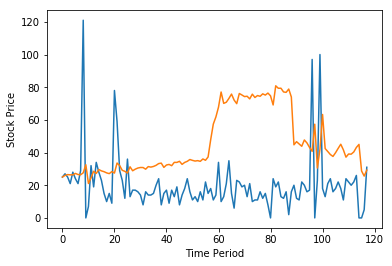

In [45]:
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = np.square(minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY))
    rmse_val = sess.run(rmse, feed_dict={targets: denormalizedTestY_feed, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [46]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [47]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

36.946839912543631

In [48]:
rootMeanSquaredError(denormalizedTestY_preprocessed,denormalizedTestPredictY)

44.804596866487358

In [49]:
121 in denormalizedTestY

True

In [50]:
denormalizedTestY_preprocessed

array([  5.        ,   5.19615242,   5.        ,   4.58257569,
         5.29150262,   4.89897949,   4.58257569,   5.38516481,
        11.        ,   0.        ,   2.64575131,   5.65685425,
         4.35889894,   5.83095189,   5.29150262,   4.79583152,
         3.87298335,   3.16227766,   3.87298335,   3.        ,
         8.83176087,   7.68114575,   5.38516481,   4.79583152,
         3.46410162,   6.        ,   3.60555128,   4.12310563,
         4.12310563,   4.        ,   3.74165739,   2.82842712,
         4.        ,   3.74165739,   3.74165739,   3.87298335,
         4.47213595,   4.89897949,   2.82842712,   3.87298335,
         4.12310563,   3.        ,   4.12310563,   3.60555128,
         4.35889894,   2.82842712,   3.74165739,   4.24264069,
         4.89897949,   4.        ,   3.31662479,   3.60555128,
         3.16227766,   4.        ,   3.31662479,   4.69041576,
         3.87298335,   4.24264069,   3.31662479,   3.74165739,
         5.83095189,   3.16227766,   3.60555128,   4.58